# Model validation altimetry

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Load packages

In [ ]:
import matplotlib.pyplot as plt
import modelskill as ms
import helper as h
import mikeio
import warnings

In [32]:
obs_fldr = "../observations/" 
alt_fldr = "../observations/altimetry/"
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

save_png = False if "sample" in mr_fldr else True

### Get altimetry obs

In [33]:
altlist = h.get_altimetry_obs()
altlist

[<TrackObservation>: 3a
 Time: 2022-01-01 10:56:29 - 2023-12-30 21:10:09
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: 3b
 Time: 2022-01-01 10:17:24 - 2023-12-30 10:45:30
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: 6a
 Time: 2022-01-01 20:26:14 - 2023-12-30 16:14:10
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: c2
 Time: 2022-01-01 21:43:21.046000 - 2023-12-29 09:22:09.814000
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: j3
 Time: 2022-01-01 20:25:44.605000 - 2023-12-30 09:18:30.970000
 Quantity: Significant Wave Height [meter],
 <TrackObservation>: sa
 Time: 2022-01-01 04:50:12.885000 - 2023-12-30 18:41:02.222000
 Quantity: Significant Wave Height [meter]]

### Model validation

In [34]:
if "sample" in mr_fldr:
    mr = ms.DfsuModelResult(mikeio.read(mr_fn)[0], name="MIKE21")
else:
    # Exclude the first two days of 2022 to avoid spin-up effects (only for full output data)
    mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[0], name="MIKE21")


In [35]:
cmps = []
match_years = ["2022", "2023"] # You can choose a specific time period here

for o in altlist:
    print(f"Processing {o.name}...")
    try:
        for year in match_years:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cmp = ms.match(obs=o.sel(time=year), mod=mr)
                cmps.append(cmp)
    except Exception as e:
        print(e)

cc = ms.ComparerCollection(cmps)

Processing 3a...
Processing 3b...
Processing 6a...
Processing c2...
Processing j3...
Processing sa...


### Skill table

In [36]:
cc.skill().round(4)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
3a,28783,0.1506,0.3418,0.3068,0.2561,0.9619,0.2023,0.8776
3b,30489,0.1180,0.3416,0.3206,0.2555,0.9518,0.2168,0.8648
6a,37431,0.1688,0.3463,0.3023,0.2561,0.9610,0.2013,0.8721
c2,28383,0.1227,0.3438,0.3211,0.2487,0.9598,0.2106,0.8556
j3,34764,0.0761,0.3207,0.3116,0.2372,0.9590,0.1983,0.8855
sa,25125,0.0979,0.3283,0.3133,0.2323,0.9578,0.2037,0.8741


### Scatter plots

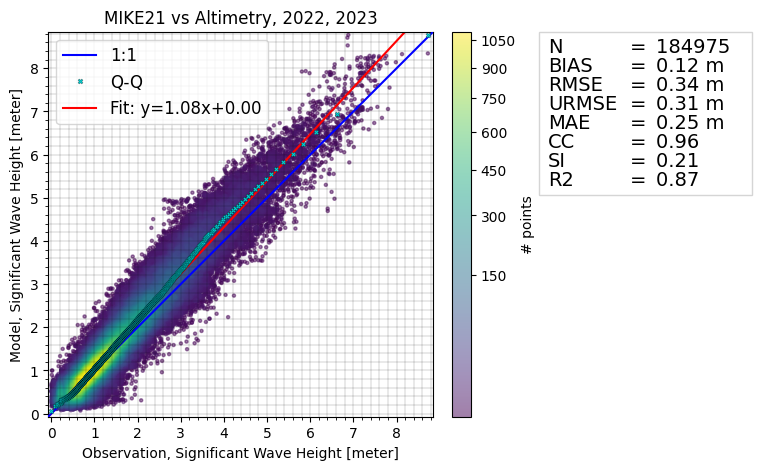

In [37]:
cc.plot.scatter(skill_table=True, show_points=True, figsize=(6,5))
plt.title("MIKE21 vs Altimetry, " + ", ".join(match_years))
if save_png: 
    plt.savefig("../figures/altimetry_comparison.png", bbox_inches="tight")

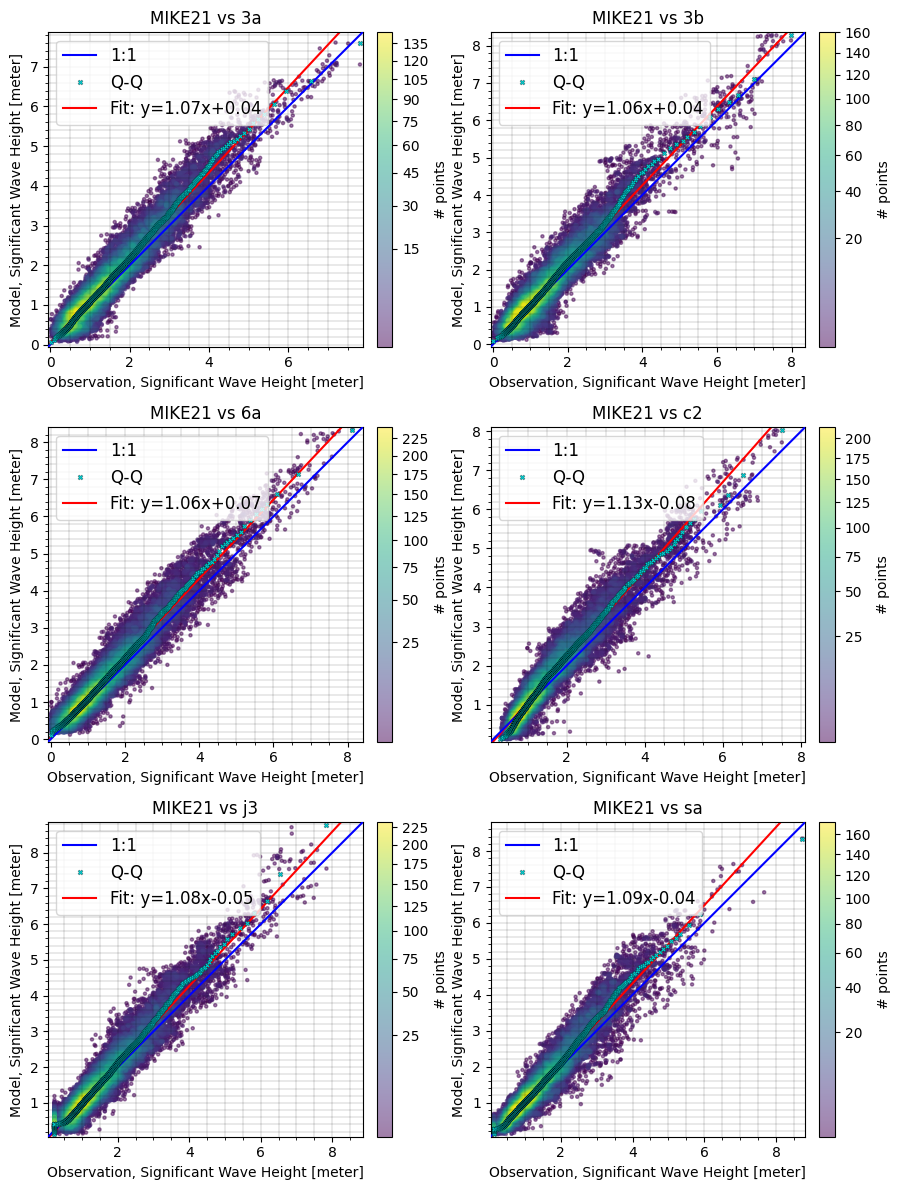

In [38]:
fig, axs = plt.subplots(-(-len(cc)//2), 2, figsize=(9,len(cc)*2))
axs = axs.flatten()
for i in range(len(cc)):
    cc[i].sel().plot.scatter(ax=axs[i], show_points=True)

if len(cc) % 2 != 0:
    axs[-1].axis("off")
plt.tight_layout()
plt.show()